In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import scipy.stats as stats
import numpy as np

In [392]:
df = pd.read_csv('train.csv')

In [393]:
the_columns = ['HomePlanet', 'Destination']

boolean_cols = ['VIP', 'CryoSleep', 'Transported']

data = df.dropna(subset = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'RoomService']).copy()

for columns in data.select_dtypes(include=['float64']).columns.tolist():
    data[columns] = data[columns].fillna(data[columns].mean())




dummy = pd.get_dummies(data[the_columns])
data = pd.concat([data, dummy], axis=1)

for col in boolean_cols:
    
    data[col] = data[col].astype('bool').astype('int')

data = data.drop(columns = ['HomePlanet', 'Name', 'Cabin', 'Destination'])

data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,0,0,0,1
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,0,0,1
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,0,0,1
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,1,0,1,0,0
8689,9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0
8690,9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,0,0,0,0,1
8691,9280_01,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,0,1,0,1,0,0


In [407]:
data.select_dtypes(include = ['float64'])

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0


In [394]:
data.select_dtypes(include = ['float64']).columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

In [395]:
master_df = pd.DataFrame(columns = ['t_statistic', 'p_value', 'col'])

for num, col in enumerate(data.select_dtypes(include = ['float64']).columns):
    t_statistic, p_value = stats.ttest_ind(data[col][data['Transported'] == 0], data[col][data['Transported'] == 1])
    master_df.loc[num] = [t_statistic, p_value, col]

In [396]:
master_df

,t_statistic,p_value,col
0,6.664133,2.844689e-11,Age
1,22.187227,8.557207e-106,RoomService
2,-4.205010,2.640096e-05,FoodCourt
3,-1.061209,2.886281e-01,ShoppingMall
4,19.600545,1.578404e-83,Spa
5,18.471253,1.384061e-74,VRDeck


In [397]:
def chi2_test(train, columns_list):
    '''
    Runs a chi2 test on all items in a list of lists and returns a pandas dataframe
    '''
    for col in columns_list:
        value_list = [str(value) for value in train[col]]
        train[col] = np.array(value_list, dtype=object)

    chi_df = pd.DataFrame({
        'feature': [],
        'chi2': [],
        'p': [],
        'degf': [],
        'expected': []
    })

    for iteration, col in enumerate(columns_list):
        observed = pd.crosstab(train[col], train['Transported'])
        chi2, p, degf, expected = stats.chi2_contingency(observed, correction=False)

        chi_df.loc[iteration + 1] = [col, chi2, p, degf, expected]

    return chi_df

In [398]:
data.select_dtypes(include = ['int64', 'uint8']).columns.tolist()

['CryoSleep',
 'VIP',
 'Transported',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e']

In [399]:
chi_df = chi2_test(data, data.select_dtypes(include = ['int64', 'uint8']).columns.tolist())

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [402]:
chi_df

,feature,chi2,p,degf,expected
1,CryoSleep,1691.148359,0.000000e+00,1,"[[2461.088550406609, 2507.911449593391], [1375..."
2,VIP,9.193379,2.428921e-03,1,"[[3745.371627726862, 3816.628372273138], [91.6..."
3,Transported,7747.000000,0.000000e+00,1,"[[1900.4219697947592, 1936.5780302052408], [19..."
4,HomePlanet_Earth,228.102876,1.545543e-51,1,"[[1763.2270556344392, 1796.7729443655608], [20..."
5,HomePlanet_Europa,259.544923,2.156315e-58,1,"[[2865.7392539047373, 2920.2607460952627], [97..."
6,HomePlanet_Mars,1.662770,1.972297e-01,1,"[[3045.0336904608234, 3102.9663095391766], [79..."
7,Destination_55 Cancri e,95.786357,1.279746e-22,1,"[[3015.3163805344, 3072.6836194656], [821.6836..."
8,Destination_PSO J318.5-22,0.051343,8.207422e-01,1,"[[3479.8969923841487, 3546.1030076158513], [35..."
9,Destination_TRAPPIST-1e,73.275074,1.127832e-17,1,"[[1178.786627081451, 1201.213372918549], [2658..."


In [404]:
chi_df[(chi_df.p < .05) & (chi_df.feature != 'Transported')]

,feature,chi2,p,degf,expected
1,CryoSleep,1691.148359,0.000000e+00,1,"[[2461.088550406609, 2507.911449593391], [1375..."
2,VIP,9.193379,2.428921e-03,1,"[[3745.371627726862, 3816.628372273138], [91.6..."
4,HomePlanet_Earth,228.102876,1.545543e-51,1,"[[1763.2270556344392, 1796.7729443655608], [20..."
5,HomePlanet_Europa,259.544923,2.156315e-58,1,"[[2865.7392539047373, 2920.2607460952627], [97..."
7,Destination_55 Cancri e,95.786357,1.279746e-22,1,"[[3015.3163805344, 3072.6836194656], [821.6836..."
9,Destination_TRAPPIST-1e,73.275074,1.127832e-17,1,"[[1178.786627081451, 1201.213372918549], [2658..."


In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7747 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                7747 non-null   object 
 1   CryoSleep                  7747 non-null   int64  
 2   Age                        7747 non-null   float64
 3   VIP                        7747 non-null   int64  
 4   RoomService                7747 non-null   float64
 5   FoodCourt                  7747 non-null   float64
 6   ShoppingMall               7747 non-null   float64
 7   Spa                        7747 non-null   float64
 8   VRDeck                     7747 non-null   float64
 9   Transported                7747 non-null   int64  
 10  HomePlanet_Earth           7747 non-null   uint8  
 11  HomePlanet_Europa          7747 non-null   uint8  
 12  HomePlanet_Mars            7747 non-null   uint8  
 13  Destination_55 Cancri e    7747 non-null   uint8

In [3]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [22]:
len(df.PassengerId.unique())

8693

In [12]:
df.shape

(8693, 14)

In [13]:
df.HomePlanet[df.HomePlanet.isnull()].shape

(201,)

In [9]:
df.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [19]:
df.dropna(subset = ['HomePlanet']).shape[0] - df.shape[0]

-201

In [ ]:
dummy = pd.get_dummies(data[the_columns], drop_first=True)

In [34]:
len(df[df.CryoSleep.isnull()])

217

In [37]:
df[df.Cabin.isnull()].shape

(199, 14)

In [43]:
df[df.Destination.isnull()].shape

(182, 14)

In [49]:
df[df.Age.isnull()].shape

(179, 14)

In [54]:
df.Age.fillna(df.Age.mean())

0       39.0
1       24.0
2       58.0
3       33.0
4       16.0
        ... 
8688    41.0
8689    18.0
8690    26.0
8691    32.0
8692    44.0
Name: Age, Length: 8693, dtype: float64

In [66]:
df[df.VIP.isnull()].shape

(203, 14)

In [72]:
df[df.RoomService.isnull()].shape

(181, 14)

In [76]:
df[df.FoodCourt.isnull()].shape

(183, 14)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [86]:
for columns in data.select_dtypes(include=['float64']).columns.tolist():
    data[columns] = data[columns].fillna(data[columns].mean())

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck


In [95]:
data

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,0
1,0002_01,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0,0
2,0003_01,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0
3,0003_02,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1,0
4,0004_01,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,1,0
8689,9278_01,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0,0
8690,9279_01,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,0,0
8691,9280_01,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,1,0


In [ ]:
data.FoodCourt = data.FoodCourt.fillna(data.FoodCourt.mean())
data.Age = data.Age.fillna(data.Age.mean())

In [108]:
data.HomePlanet_Europa = data.HomePlanet_Europa.astype('int')

0       1
1       0
2       1
3       1
4       0
       ..
8688    1
8689    0
8690    0
8691    1
8692    1
Name: HomePlanet_Europa, Length: 7574, dtype: int64

In [117]:
data.VIP.astype('bool').astype('int')

0       0
1       0
2       1
3       0
4       0
       ..
8688    1
8689    0
8690    0
8691    0
8692    0
Name: VIP, Length: 7574, dtype: int64

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7574 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        7574 non-null   object 
 1   CryoSleep          7574 non-null   object 
 2   Cabin              7574 non-null   object 
 3   Destination        7574 non-null   object 
 4   Age                7574 non-null   float64
 5   VIP                7574 non-null   object 
 6   RoomService        7574 non-null   float64
 7   FoodCourt          7574 non-null   float64
 8   ShoppingMall       7574 non-null   float64
 9   Spa                7574 non-null   float64
 10  VRDeck             7574 non-null   float64
 11  Transported        7574 non-null   bool   
 12  HomePlanet_Europa  7574 non-null   uint8  
 13  HomePlanet_Mars    7574 non-null   uint8  
dtypes: bool(1), float64(6), object(5), uint8(2)
memory usage: 732.3+ KB


In [118]:
data

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,0
1,0002_01,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,0
2,0003_01,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,0
3,0003_02,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,0
4,0004_01,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,0
8689,9278_01,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,0,0
8690,9279_01,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,0,0
8691,9280_01,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,1,0


In [ ]:
data.select_dtypes(include =['bool'])

In [134]:
data.isnull().sum()

PassengerId                  0
CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
dtype: int64

# pre
> * filled nulls with mean in all float64 columns

> * dropped Cabin column because there were too many unique strings

> * dropped nulls in RoomService becuse it was 181 rows
> * dropped nulls in vip because it was only 203 samples
> * dropped nulls in Destination because it was only 182 samples
> * dropped nulls in CryoSleep because it was only 217 samples

> * dropped nulls because it only accounted for 201 out of 8693 rows.
> * dropped the name column because we have passenger id

> * converted converted the boolean values of 'VIP', 'CryoSleep', 'Transported' to 0 or 1

> * encoded homeplannet because it was catagorical then dropped homeplannet column
> * encoded destination 

In [177]:
def new_visual_univariate_findings(df):
    '''
    This function displays all of our histplots during the univariate analysis
    '''
    count = 0
    for col in df.select_dtypes(include=['object']).columns:                   

        num_cols = len(df.select_dtypes(exclude=['object']).columns)
        num_rows, num_cols_subplot = divmod(num_cols, 3)
        
        if num_cols_subplot > 0:
            num_rows += 1

        fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
        if count < 1:
            for i, col in enumerate(df.select_dtypes(exclude=['object']).columns):
                
                row_idx, col_idx = divmod(i, 3)
                sns.histplot(df[col], ax=axes[row_idx, col_idx])
                axes[row_idx, col_idx].set_title(f'Histogram of {col}')
            
            

            plt.tight_layout()
            plt.show()

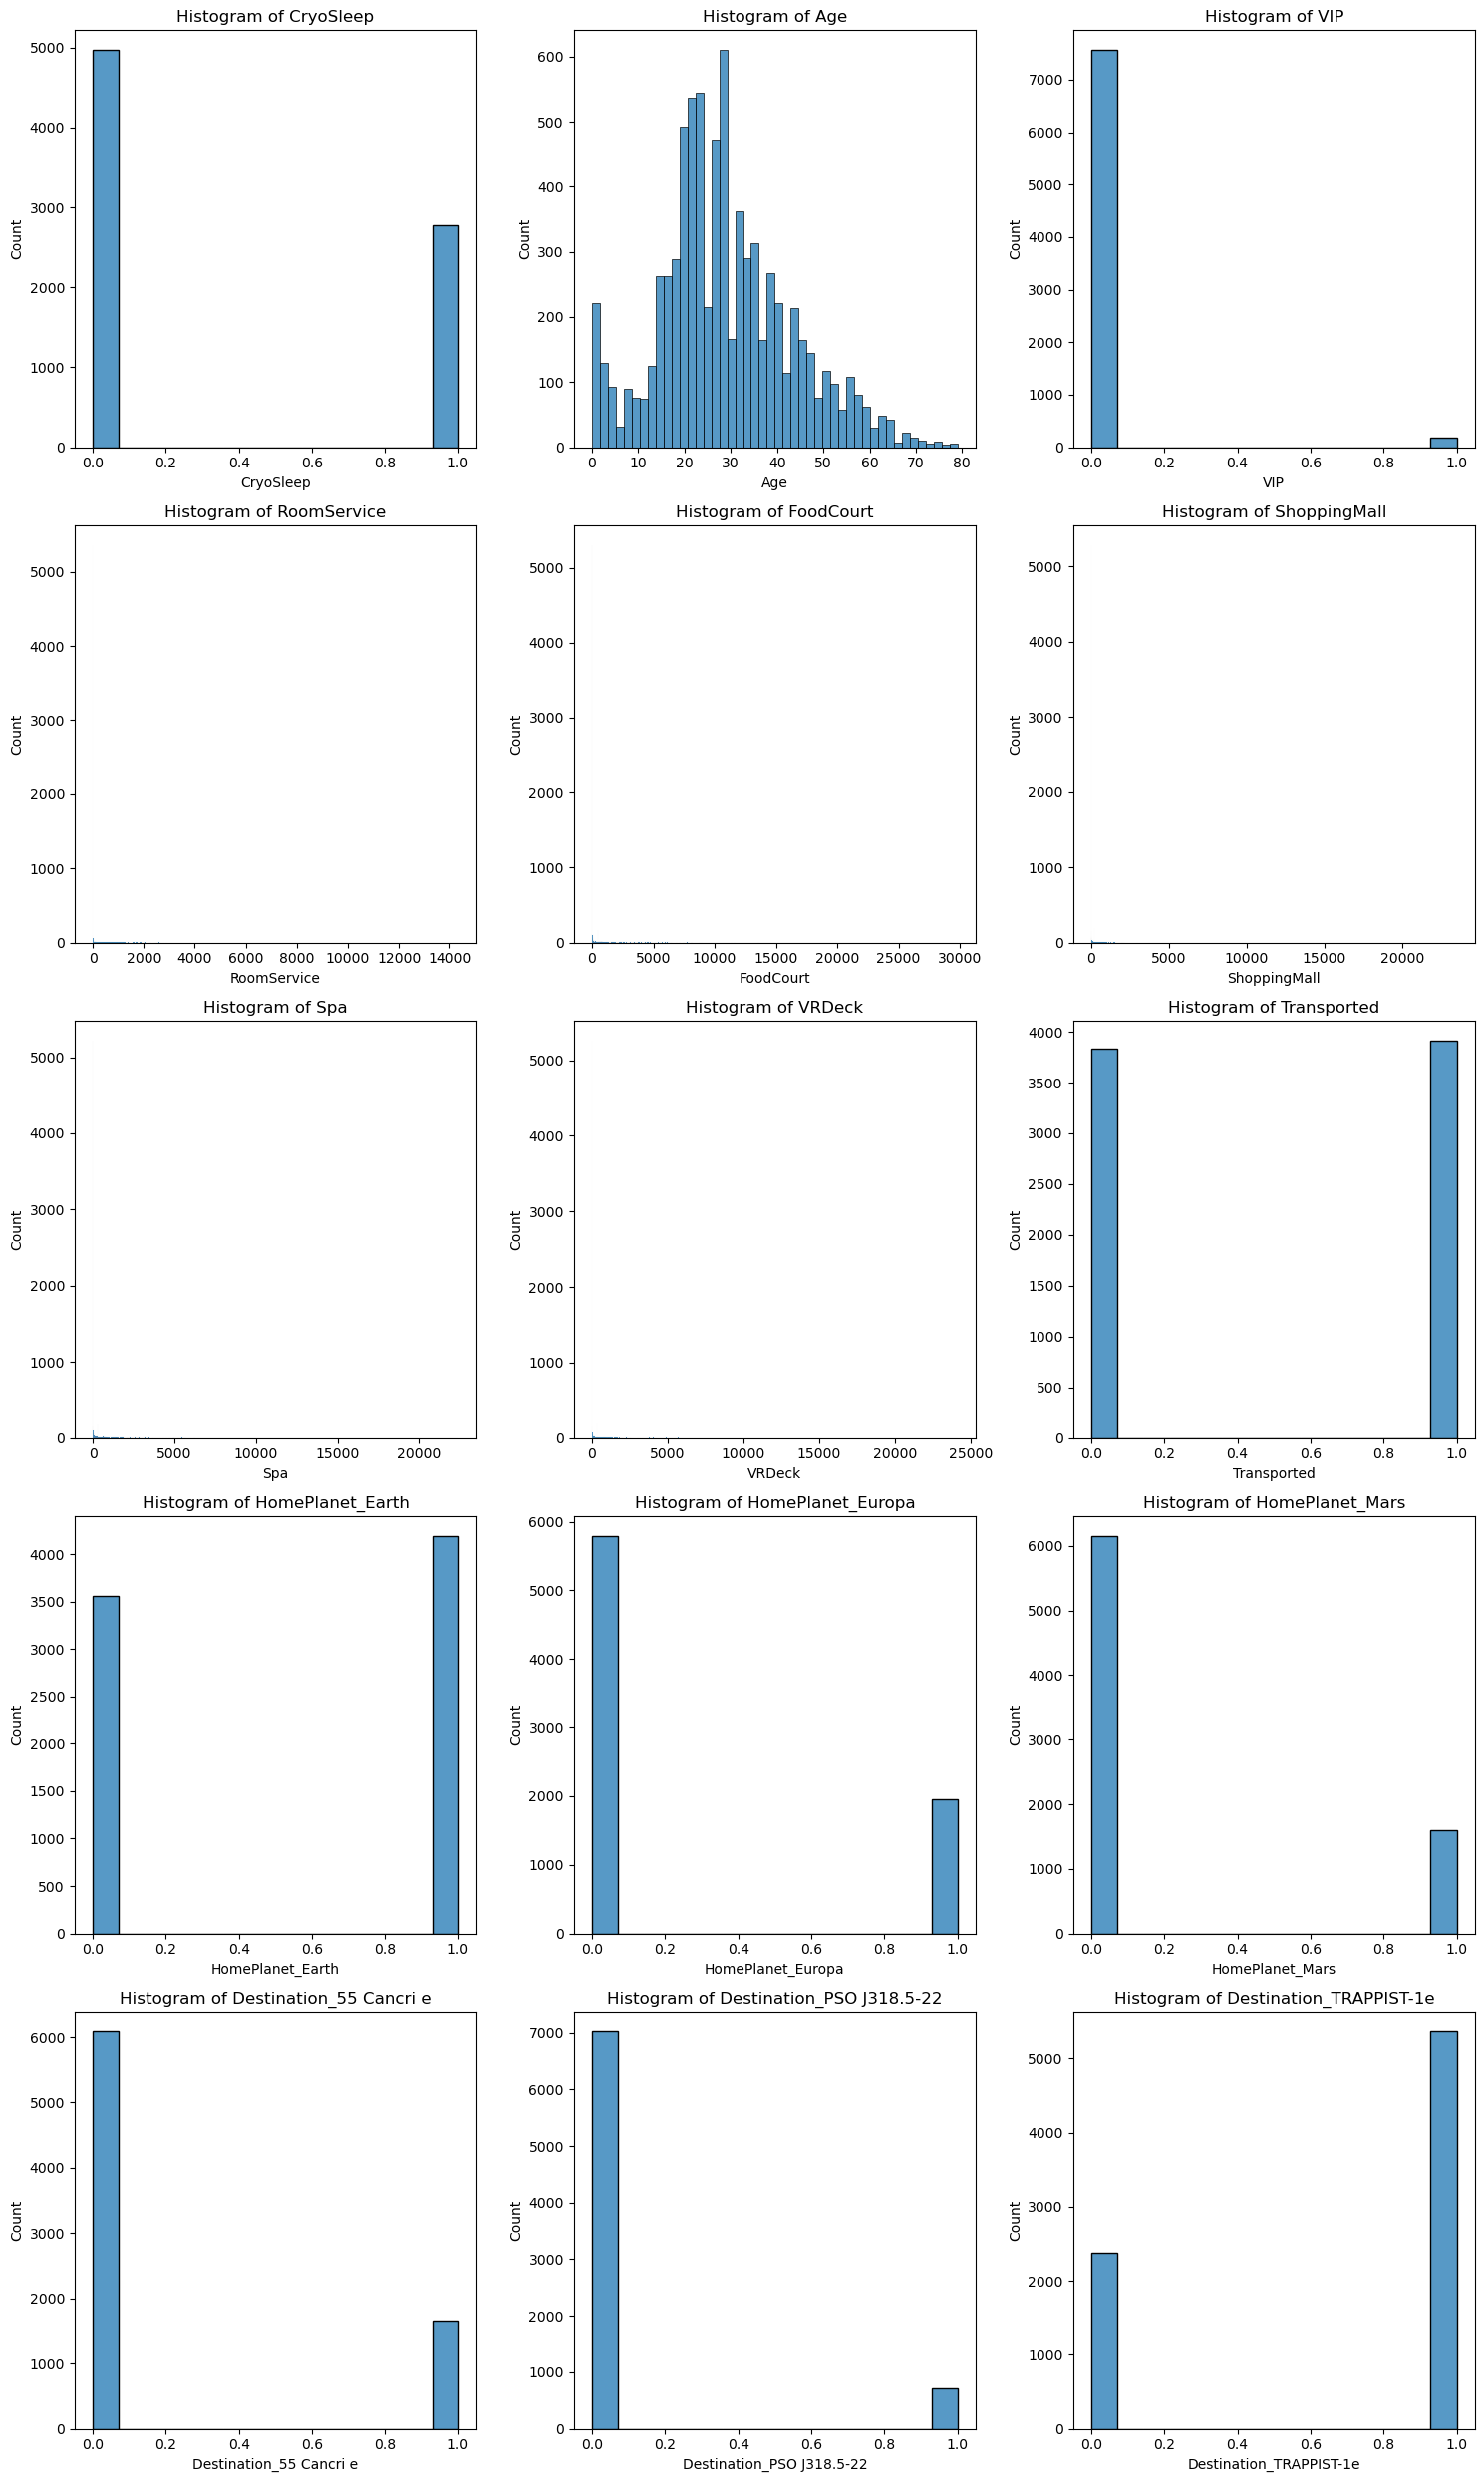

In [178]:
new_visual_univariate_findings(data)

In [179]:
data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,0,0,0,1
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,0,0,1
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,0,0,1
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,1,0,1,0,0
8689,9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0
8690,9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,0,0,0,0,1
8691,9280_01,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,0,1,0,1,0,0


In [180]:
def new_visual_univariate_findings_boxplots(df):
    '''
    This function displays all of our histplots during the univariate analysis
    '''
    count = 0
    for col in df.select_dtypes(include=['object']).columns:                   

        num_cols = len(df.select_dtypes(exclude=['object']).columns)
        num_rows, num_cols_subplot = divmod(num_cols, 3)
        
        if num_cols_subplot > 0:
            num_rows += 1

        fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
        if count < 1:
            for i, col in enumerate(df.select_dtypes(exclude=['object']).columns):
                
                row_idx, col_idx = divmod(i, 3)
                
                sns.boxplot(df[col], ax=axes[row_idx, col_idx])
                
                
                axes[row_idx, col_idx].set_title(f'Histogram of {col}')
            
            

            plt.tight_layout()
            plt.show()

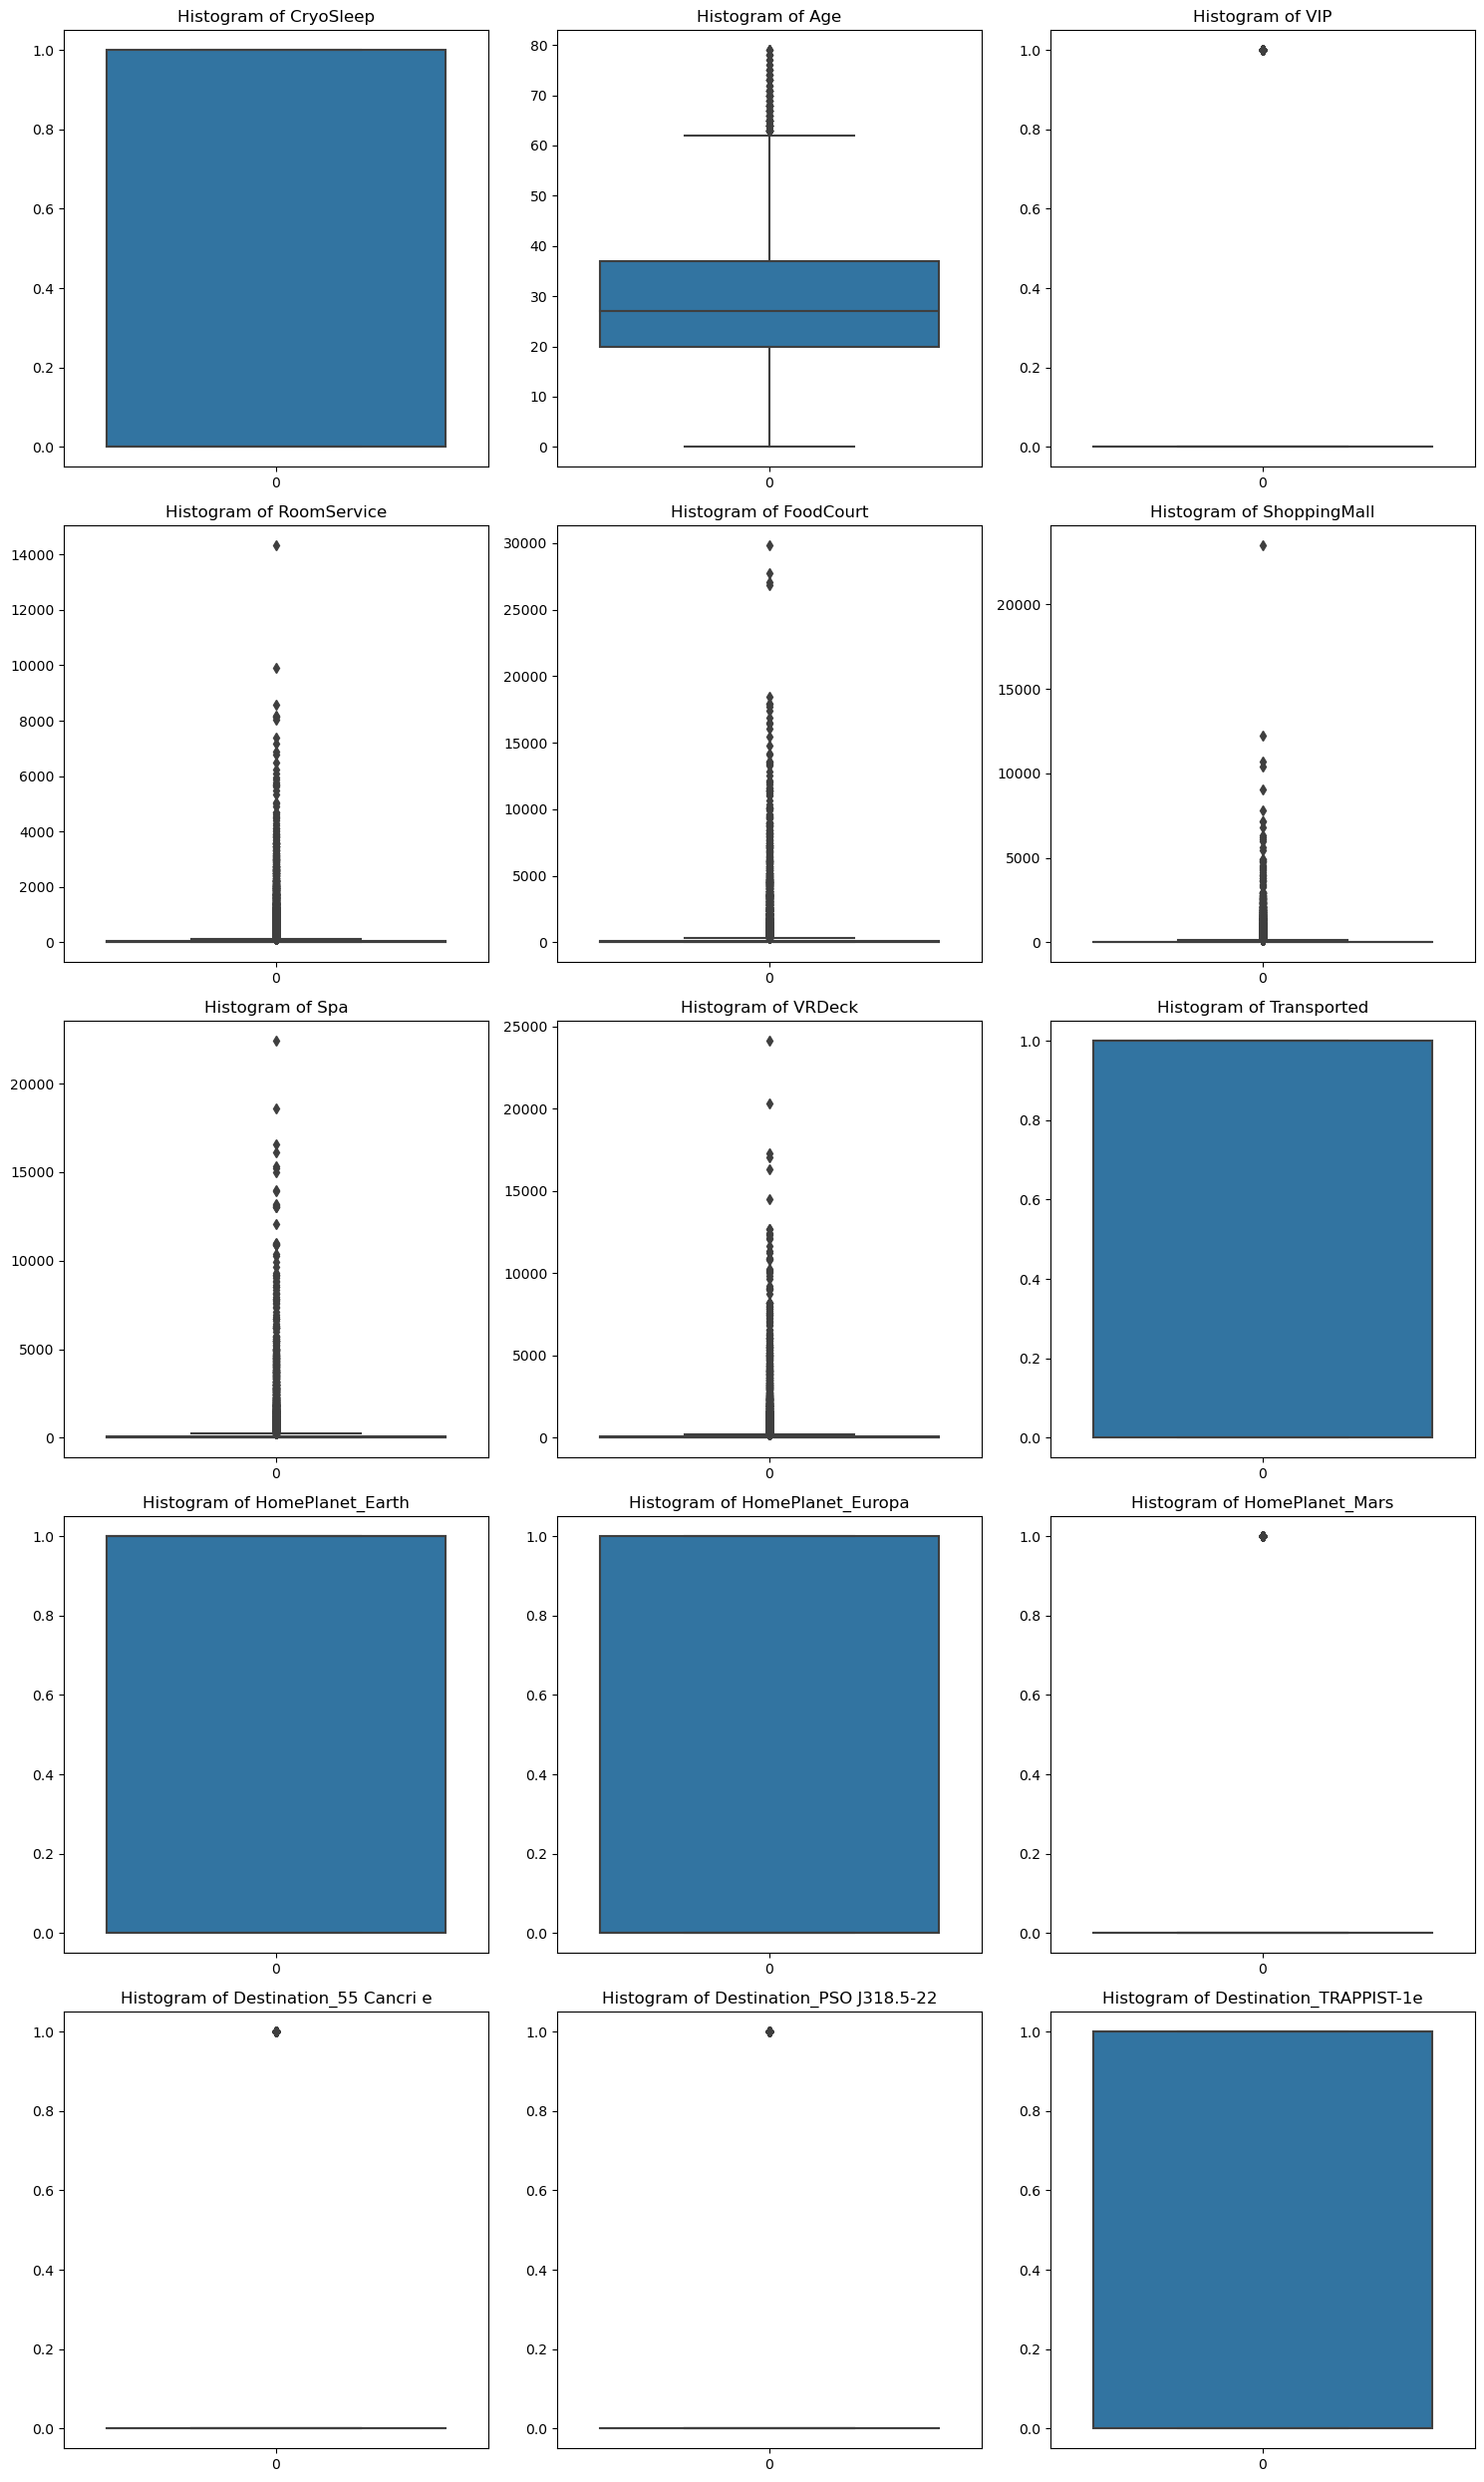

In [181]:
new_visual_univariate_findings_boxplots(data)

In [182]:
data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,1,0,0,0,0,1
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,0,0,0,1
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,0,0,0,1
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,1,0,1,0,0
8689,9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0
8690,9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,1,0,0,0,0,1
8691,9280_01,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,0,1,0,1,0,0


In [231]:
def z_score(df):

    for col in df.select_dtypes(exclude=['object', 'uint8', 'int64']).columns:
        
        df[f'{col}_zscores'] = (df[col] - df[col].mean()) / df[col].std()
        
        print(df[f'{col}_zscores'][df[f'{col}_zscores'].abs() < 2])
        
        df[f'{col}_zscores'] = df[f'{col}_zscores'][df[f'{col}_zscores'].abs() < 2]
            
            
            
        plt.hist(df[col][df[f'{col}_zscores'].abs() < 2])
        plt.title(col.replace('_',' ').capitalize())
        plt.show()


0       0.705555
1      -0.341207
3       0.286850
4      -0.899479
5       1.054475
          ...   
8688    0.845123
8689   -0.759911
8690   -0.201638
8691    0.217066
8692    1.054475
Name: Age_zscores, Length: 7288, dtype: float64


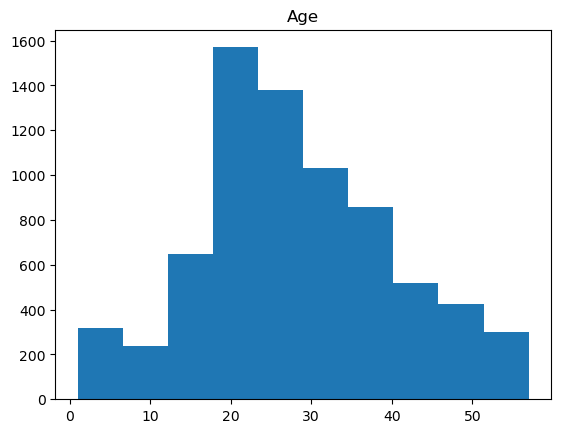

0      -0.337062
1      -0.173060
2      -0.272364
3      -0.337062
4       0.118834
          ...   
8688   -0.337062
8689   -0.337062
8690   -0.337062
8691   -0.337062
8692   -0.147481
Name: RoomService_zscores, Length: 7452, dtype: float64


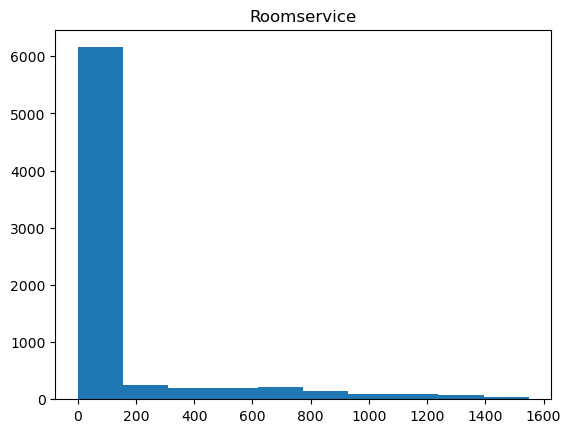

0      -0.289178
1      -0.283599
2       1.927548
3       0.506140
4      -0.245786
          ...   
8685   -0.289178
8686    0.421215
8689   -0.289178
8690   -0.289178
8691    0.361086
Name: FoodCourt_zscores, Length: 7471, dtype: float64


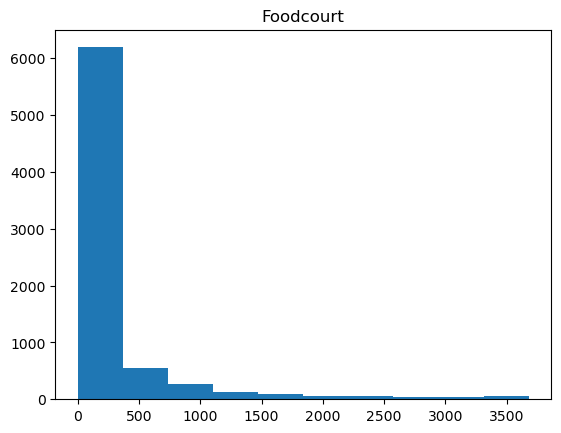

0      -0.289294
1      -0.248719
2      -0.289294
3       0.312842
4      -0.044220
          ...   
8686   -0.289294
8688   -0.289294
8689   -0.289294
8691   -0.289294
8692   -0.289294
Name: ShoppingMall_zscores, Length: 7523, dtype: float64


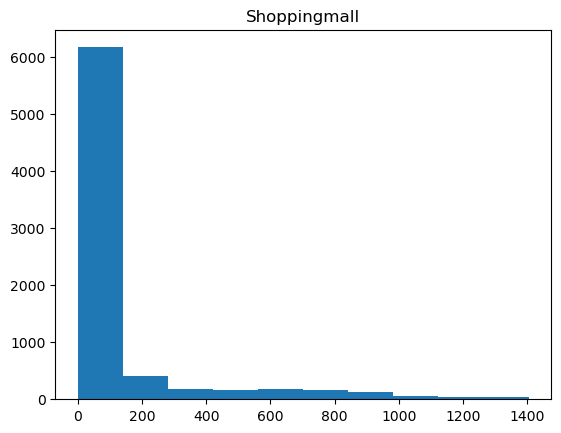

0      -0.275570
1       0.208301
4       0.222403
5      -0.019092
6      -0.275570
          ...   
8688    1.172518
8689   -0.275570
8690   -0.274688
8691    0.035553
8692   -0.275570
Name: Spa_zscores, Length: 7506, dtype: float64


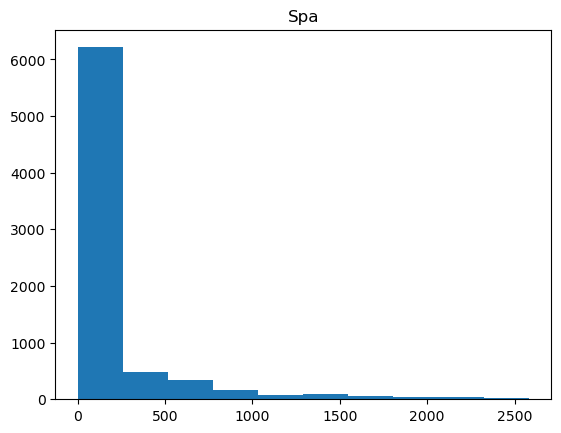

0      -0.269156
1      -0.230500
2      -0.226108
3      -0.099599
4      -0.267399
          ...   
8686   -0.239286
8688   -0.204145
8689   -0.269156
8690   -0.269156
8692   -0.258613
Name: VRDeck_zscores, Length: 7534, dtype: float64


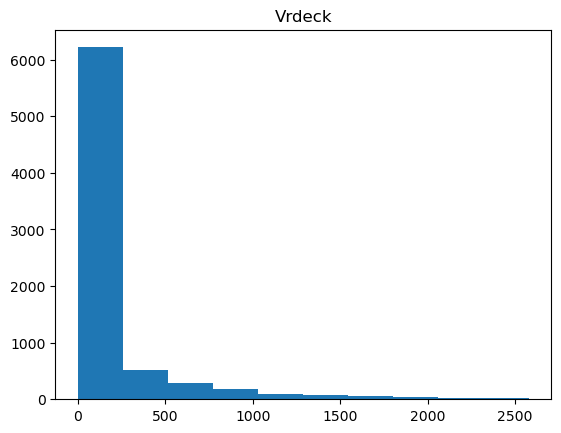

0       0.893112
1      -0.335398
3       0.401708
4      -0.990603
5       1.302615
          ...   
8688    1.056913
8689   -0.826801
8690   -0.171596
8691    0.319807
8692    1.302615
Name: Age_zscores_zscores, Length: 6838, dtype: float64


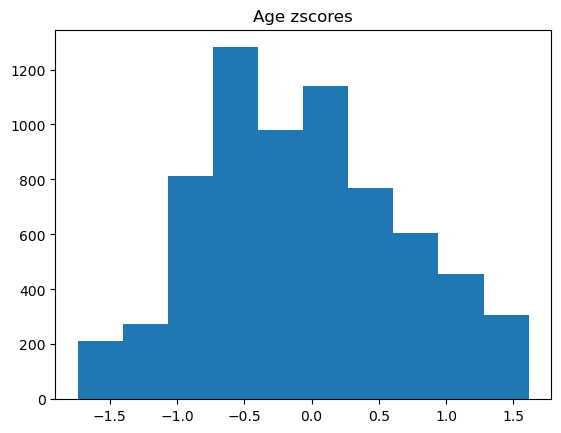

0      -0.417024
1      -0.041739
2      -0.268976
3      -0.417024
4       0.626199
          ...   
8688   -0.417024
8689   -0.417024
8690   -0.417024
8691   -0.417024
8692    0.016792
Name: RoomService_zscores_zscores, Length: 6906, dtype: float64


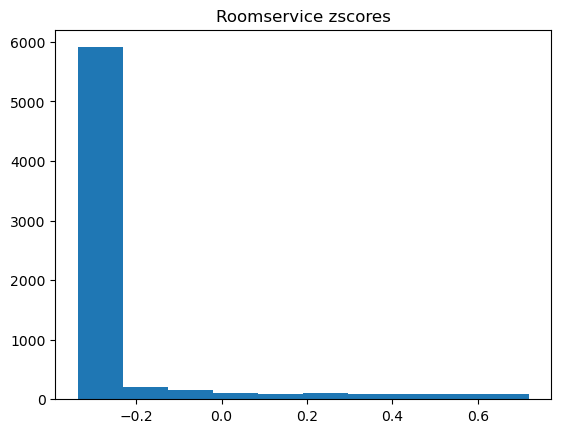

0      -0.382653
1      -0.366710
3       1.890077
4      -0.258653
5       0.472942
          ...   
8685   -0.382653
8686    1.647392
8689   -0.382653
8690   -0.382653
8691    1.475565
Name: FoodCourt_zscores_zscores, Length: 7104, dtype: float64


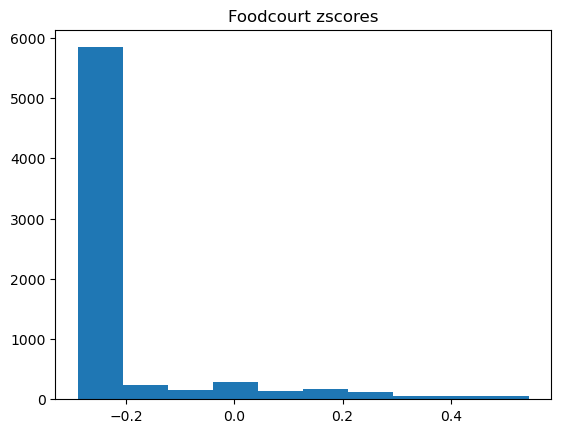

0      -0.416725
1      -0.316116
2      -0.416725
3       1.076319
4       0.190956
          ...   
8686   -0.416725
8688   -0.416725
8689   -0.416725
8691   -0.416725
8692   -0.416725
Name: ShoppingMall_zscores_zscores, Length: 6946, dtype: float64


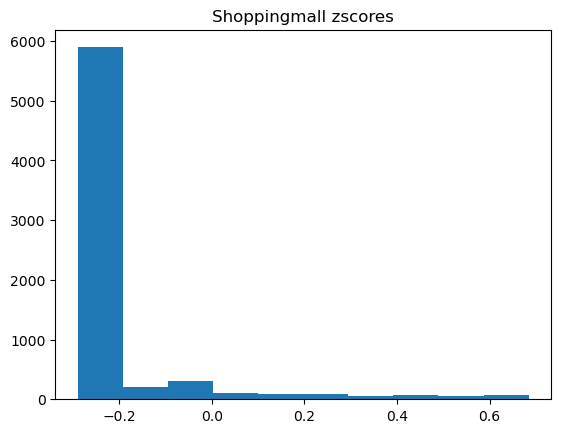

0      -0.401099
1       1.070466
4       1.113354
5       0.378911
6      -0.401099
          ...   
8686   -0.267077
8689   -0.401099
8690   -0.398418
8691    0.545099
8692   -0.401099
Name: Spa_zscores_zscores, Length: 7148, dtype: float64


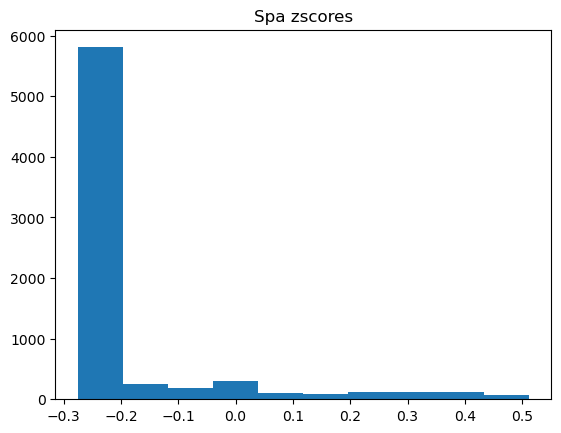

0      -0.398320
1      -0.282420
2      -0.269250
3       0.110059
4      -0.393052
          ...   
8686   -0.308761
8688   -0.203397
8689   -0.398320
8690   -0.398320
8692   -0.366711
Name: VRDeck_zscores_zscores, Length: 7158, dtype: float64


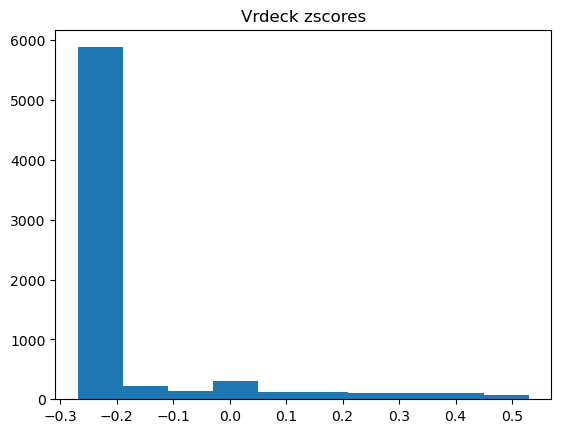

0       1.053466
1      -0.359700
3       0.488200
4      -1.113389
5       1.524522
          ...   
8688    1.241888
8689   -0.924967
8690   -0.171278
8691    0.393988
8692    1.524522
Name: Age_zscores_zscores_zscores, Length: 6552, dtype: float64


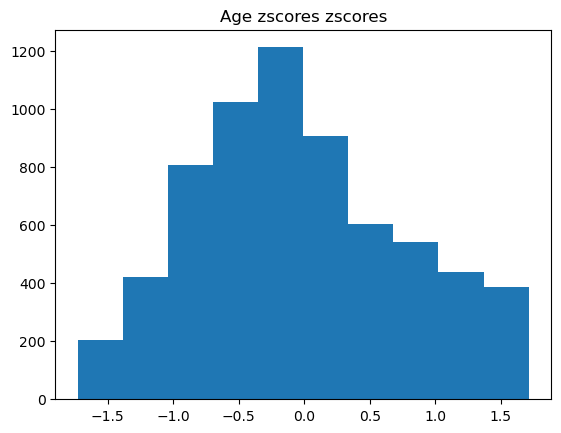

In [232]:
z_score(data)

In [236]:
data

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,...,ShoppingMall_zscores,Spa_zscores,VRDeck_zscores,Age_zscores_zscores,RoomService_zscores_zscores,FoodCourt_zscores_zscores,ShoppingMall_zscores_zscores,Spa_zscores_zscores,VRDeck_zscores_zscores,Age_zscores_zscores_zscores
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,...,-0.289294,-0.275570,-0.269156,0.893112,-0.417024,-0.382653,-0.416725,-0.401099,-0.398320,1.053466
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,...,-0.248719,0.208301,-0.230500,-0.335398,-0.041739,-0.366710,-0.316116,1.070466,-0.282420,-0.359700
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,...,-0.289294,NaN,-0.226108,NaN,-0.268976,NaN,-0.416725,NaN,-0.269250,NaN
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,...,0.312842,NaN,-0.099599,0.401708,-0.417024,1.890077,1.076319,NaN,0.110059,0.488200
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,...,-0.044220,0.222403,-0.267399,-0.990603,0.626199,-0.258653,0.190956,1.113354,-0.393052,-1.113389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,...,-0.289294,1.172518,-0.204145,1.056913,-0.417024,NaN,-0.416725,NaN,-0.203397,1.241888
8689,9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,...,-0.289294,-0.275570,-0.269156,-0.826801,-0.417024,-0.382653,-0.416725,-0.401099,-0.398320,-0.924967
8690,9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,...,NaN,-0.274688,-0.269156,-0.171596,-0.417024,-0.382653,NaN,-0.398418,-0.398320,-0.171278
8691,9280_01,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,...,-0.289294,0.035553,NaN,0.319807,-0.417024,1.475565,-0.416725,0.545099,NaN,0.393988


In [242]:
data.shape

(7747, 29)

(array([7.424e+03, 2.290e+02, 6.000e+01, 1.700e+01, 8.000e+00, 7.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([    0. ,  1432.7,  2865.4,  4298.1,  5730.8,  7163.5,  8596.2,
        10028.9, 11461.6, 12894.3, 14327. ]),
 <BarContainer object of 10 artists>)

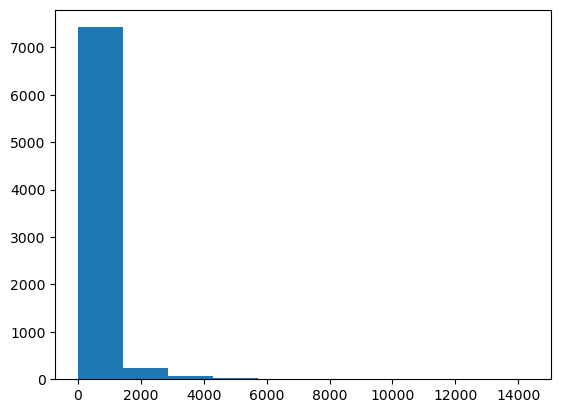

In [249]:
plt.hist(data.RoomService)

In [215]:
data[data.Age < 60].shape

(7521, 16)

In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7747 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                7747 non-null   object 
 1   CryoSleep                  7747 non-null   int64  
 2   Age                        7747 non-null   float64
 3   VIP                        7747 non-null   int64  
 4   RoomService                7747 non-null   float64
 5   FoodCourt                  7747 non-null   float64
 6   ShoppingMall               7747 non-null   float64
 7   Spa                        7747 non-null   float64
 8   VRDeck                     7747 non-null   float64
 9   Transported                7747 non-null   int64  
 10  HomePlanet_Earth           7747 non-null   uint8  
 11  HomePlanet_Europa          7747 non-null   uint8  
 12  HomePlanet_Mars            7747 non-null   uint8  
 13  Destination_55 Cancri e    7747 non-null   uint8

In [212]:
def IQR(df):
    inner_multiplier = 2

    for col in df.select_dtypes(exclude=['object', 'uint8', 'int64']).columns:
        q1 = df[col].quantile(0.25)
        q3= df[col].quantile(0.75)
        iqr= q3- q1
        
        inner_lower_fence = q1 - (inner_multiplier * iqr)
        inner_upper_fence = q3 + (inner_multiplier * iqr)
        
        new_df = df[(df[col] < inner_lower_fence) | (df[col] > inner_upper_fence)]
        
        plt.hist(new_df[col])
        plt.title(col.replace('_',' ').capitalize())
        plt.show()
        
#         print(f'Column Name: {col}', new_df ,'\n')
        
    

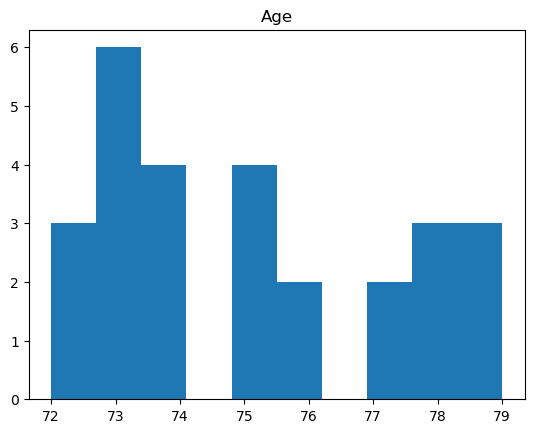

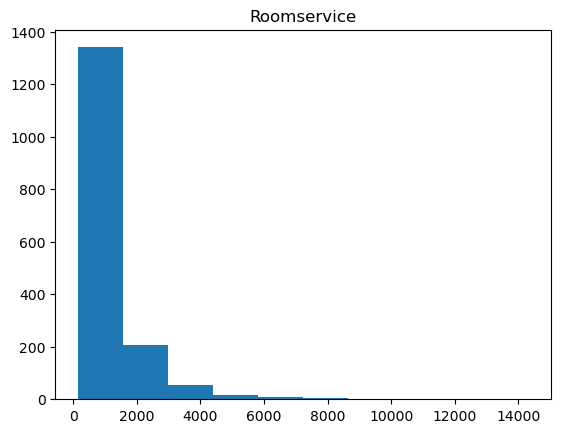

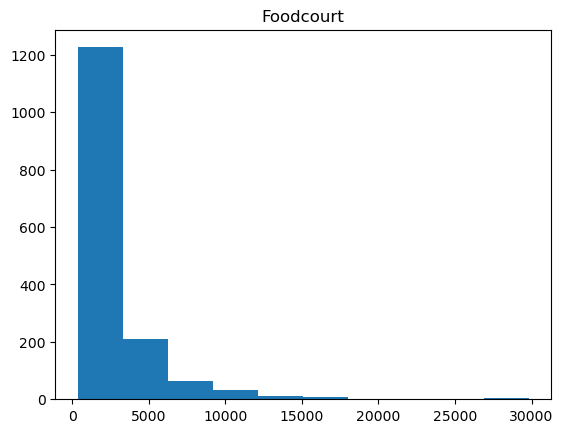

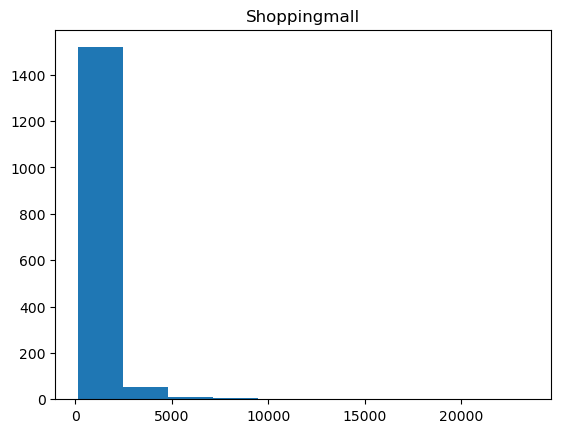

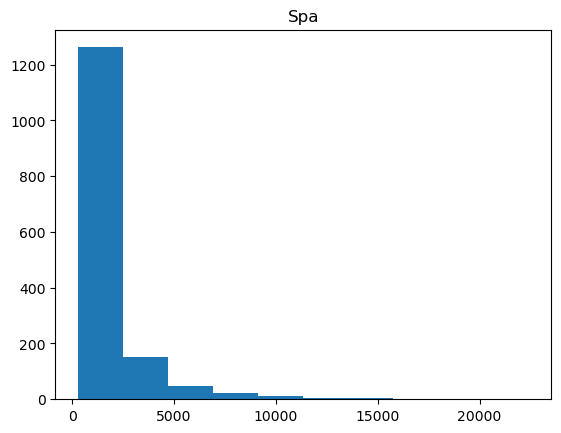

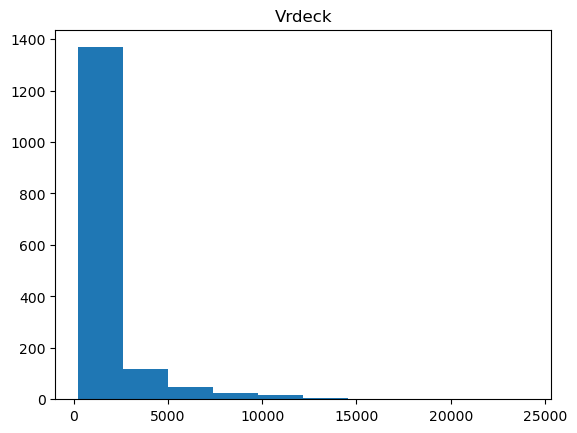

In [213]:
IQR(data)